<h1>GA</h1>

In [1]:
from data_loader import DataLoader 
from neural_network import NeuralNetwork
from visualizer import Visualizer
import tensorflow as tf
import numpy as np
import time
import random
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

In [2]:
class GeneticAlgorithm:
    def __init__(self, model, data_loader, pop_size=20, generations=5000, tournament_size=3, elite_size=2, alpha=0.1, mutation_sigma=0.1, mutation_rate=0.01):
        self.model = model
        self.data_loader = data_loader
        self.pop_size = pop_size
        self.generations = generations
        self.tournament_size = tournament_size
        self.elite_size = elite_size
        self.alpha = alpha  # BLX-alpha crossover parameter
        self.mutation_sigma = mutation_sigma  # Gaussian mutation sigma
        self.mutation_rate = mutation_rate  # Mutation rate
        self.dim = model.vector_size
        self.history = {
            'loss': [],
            'accuracy': [],
            'val_loss': [],
            'val_accuracy': [],
            'population_states': []
        }
    
    def tournament_selection(self, population, fitness):
        """Select an individual using tournament selection"""
        indices = np.random.choice(len(population), self.tournament_size, replace=False)
        best_idx = indices[np.argmin(fitness[indices])]
        return population[best_idx]
    
    def blx_alpha_crossover(self, p1, p2):
        """BLX-alpha crossover operation"""
        p1, p2 = np.array(p1), np.array(p2)
        diff = np.abs(p1 - p2)
        low = np.minimum(p1, p2) - self.alpha * diff
        high = np.maximum(p1, p2) + self.alpha * diff
        return np.random.uniform(low, high), np.random.uniform(low, high)
    
    def gaussian_mutation(self, individual):
        """Apply Gaussian mutation to an individual"""
        individual = np.asarray(individual)
        mutant = individual.copy()
        mask = np.random.rand(*mutant.shape) < self.mutation_rate
        if np.any(mask):
            mutant[mask] += np.random.normal(0, self.mutation_sigma, size=np.sum(mask))
        return mutant
    
    def elitism(self, parents, parent_fitness, offspring, offspring_fitness):
        """Elitism selection strategy"""
        # Select best 'elite_size' parents (lowest loss)
        elite_indices = np.argpartition(parent_fitness, self.elite_size)[:self.elite_size]
        elites = parents[elite_indices]
        elite_fitness = parent_fitness[elite_indices]

        # Select best offspring to fill remaining spots
        num_remaining = len(parents) - self.elite_size
        best_offspring_indices = np.argpartition(offspring_fitness, num_remaining)[:num_remaining]
        selected_offspring = offspring[best_offspring_indices]
        selected_offspring_fitness = offspring_fitness[best_offspring_indices]

        # Combine elites and selected offspring
        new_population = np.vstack((elites, selected_offspring))
        new_fitness = np.concatenate((elite_fitness, selected_offspring_fitness))

        return new_population, new_fitness
    
    def train(self):
        """Run the genetic algorithm"""
        start_time = time.time()
        x_train, y_train, x_test, y_test = self.data_loader.get_data()
        
        # Initialize population using He initialization
        population = np.array([self.model.he_vector() for _ in range(self.pop_size)])
        fitness = np.array([self.model.fitness_function(ind, x_train, y_train) for ind in population])
        
        print(f"Starting Genetic Algorithm optimization for {self.generations} generations...")
        
        for gen in range(self.generations):
            offspring = []
            
            for i in range(self.pop_size // 2):
                # Parent Selection
                p1 = self.tournament_selection(population, fitness)
                p2 = self.tournament_selection(population, fitness)

                # Crossover
                c1, c2 = self.blx_alpha_crossover(p1, p2)

                # Mutation
                c1 = self.gaussian_mutation(c1)
                c2 = self.gaussian_mutation(c2)

                offspring.extend([c1, c2])

            # Evaluate fitness
            offspring = np.array(offspring)
            offspring_fitness = np.array([self.model.fitness_function(ind, x_train, y_train) for ind in offspring])

            # Survivor selection
            population, fitness = self.elitism(population, fitness, offspring, offspring_fitness)
            
            # Log best solution
            best_idx = np.argmin(fitness)
            best_solution = population[best_idx]
            best_loss = fitness[best_idx]
            
            # Update model with best solution and evaluate
            self.model.set_weights_from_vector(best_solution)
            train_loss, train_accuracy = self.model.evaluate(x_train, y_train)
            val_loss, val_accuracy = self.model.evaluate(x_test, y_test)
            
            # Store metrics
            self.history['loss'].append(train_loss)
            self.history['accuracy'].append(train_accuracy)
            self.history['val_loss'].append(val_loss)
            self.history['val_accuracy'].append(val_accuracy)
            
            # Store population state every 500 generations
            if gen % 500 == 0 or gen == self.generations - 1:
                self.history['population_states'].append({
                    'generation': gen,
                    'population': population.copy(),
                    'fitness': fitness.copy()
                })
            
            if gen % 100 == 0 or gen == self.generations - 1:
                print(f"Generation {gen+1}/{self.generations} - Best loss: {best_loss:.4f} - Accuracy: {val_accuracy:.4f}")
        
        # Set final best solution to the model
        best_idx = np.argmin(fitness)
        best_solution = population[best_idx]
        self.model.set_weights_from_vector(best_solution)
        
        execution_time = time.time() - start_time
        
        final_train_loss, final_train_accuracy = self.model.evaluate(x_train, y_train)
        final_val_loss, final_val_accuracy = self.model.evaluate(x_test, y_test)
        
        result = {
            'best_loss': min(self.history['val_loss']),
            'final_loss': final_val_loss,
            'final_accuracy': final_val_accuracy,
            'total_iterations': self.generations,
            'execution_time': execution_time,
            'history': self.history,
            'final_population': population,
            'final_fitness': fitness
        }
        
        return result

In [3]:
def run_genetic_algorithm():
    random.seed(SEED)
    np.random.seed(SEED)
    tf.random.set_seed(SEED)
    """Main function to run the Genetic Algorithm"""
    print("Running Neural Network with Genetic Algorithm optimization...")
    
    # Initialize data loader
    data_loader = DataLoader()
    
    # Initialize neural network
    model = NeuralNetwork(input_dim=784, hidden_dim=32, output_dim=10)
    
    # Initialize GA optimizer
    ga_optimizer = GeneticAlgorithm(model, data_loader, pop_size=20, generations=3000)
    
    # Train the model
    results = ga_optimizer.train()
    
    # Save the model
    model.save_model('ga_model.pkl')
    
    # Visualize results
    visualizer = Visualizer(model, data_loader)
    visualizer.visualize_all(results)
    
    return model, results

Running Neural Network with Genetic Algorithm optimization...
Starting Genetic Algorithm optimization for 3000 generations...
Generation 1/3000 - Best loss: 2.2649 - Accuracy: 0.1472
Generation 101/3000 - Best loss: 1.4772 - Accuracy: 0.6092
Generation 201/3000 - Best loss: 0.9376 - Accuracy: 0.7086
Generation 301/3000 - Best loss: 0.6631 - Accuracy: 0.7868
Generation 401/3000 - Best loss: 0.5203 - Accuracy: 0.8208
Generation 501/3000 - Best loss: 0.4399 - Accuracy: 0.8435
Generation 601/3000 - Best loss: 0.3872 - Accuracy: 0.8654
Generation 701/3000 - Best loss: 0.3463 - Accuracy: 0.8749
Generation 801/3000 - Best loss: 0.3239 - Accuracy: 0.8762
Generation 901/3000 - Best loss: 0.3035 - Accuracy: 0.8828
Generation 1001/3000 - Best loss: 0.2864 - Accuracy: 0.8824
Generation 1101/3000 - Best loss: 0.2717 - Accuracy: 0.8812
Generation 1201/3000 - Best loss: 0.2598 - Accuracy: 0.8856
Generation 1301/3000 - Best loss: 0.2482 - Accuracy: 0.8852
Generation 1401/3000 - Best loss: 0.2383 - Acc

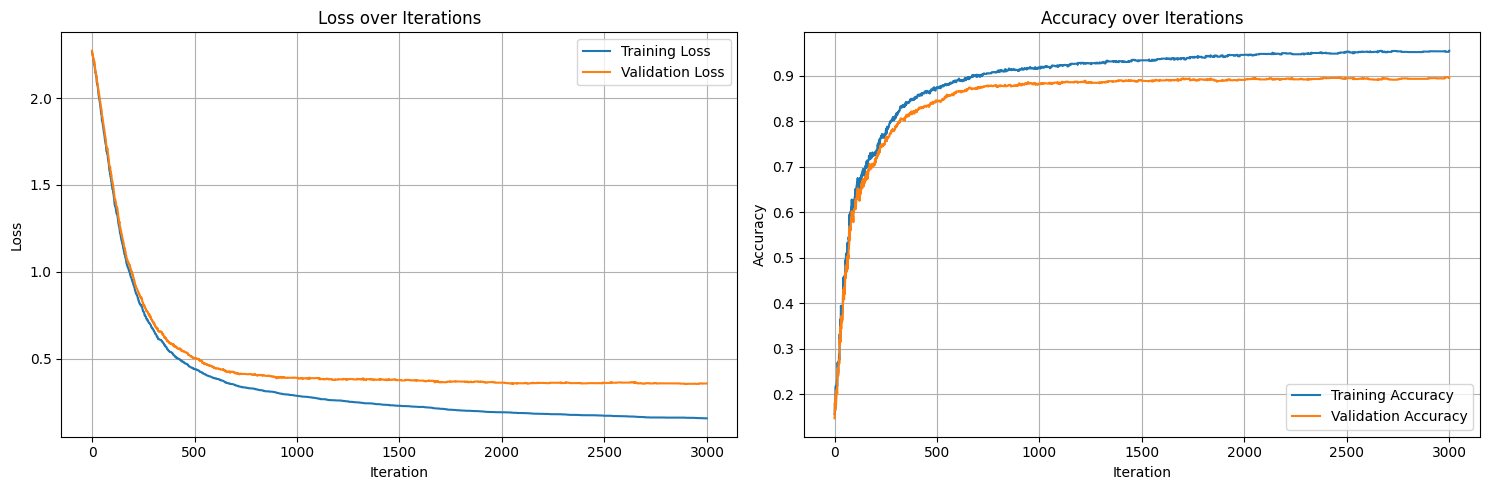

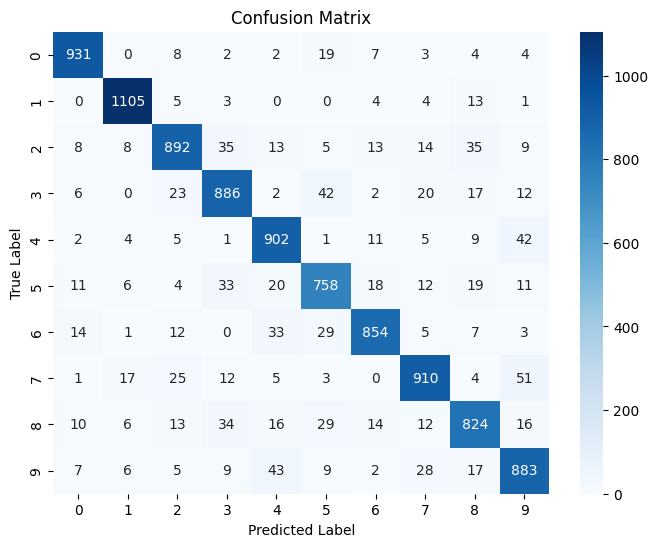

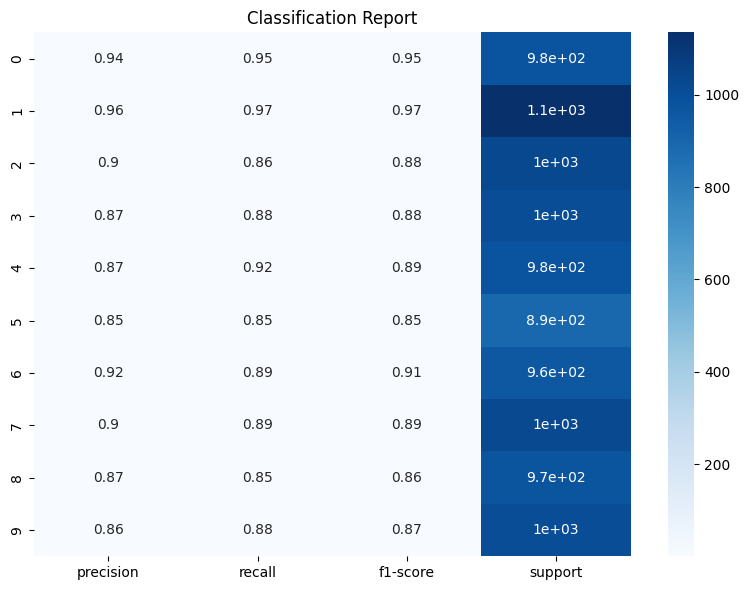

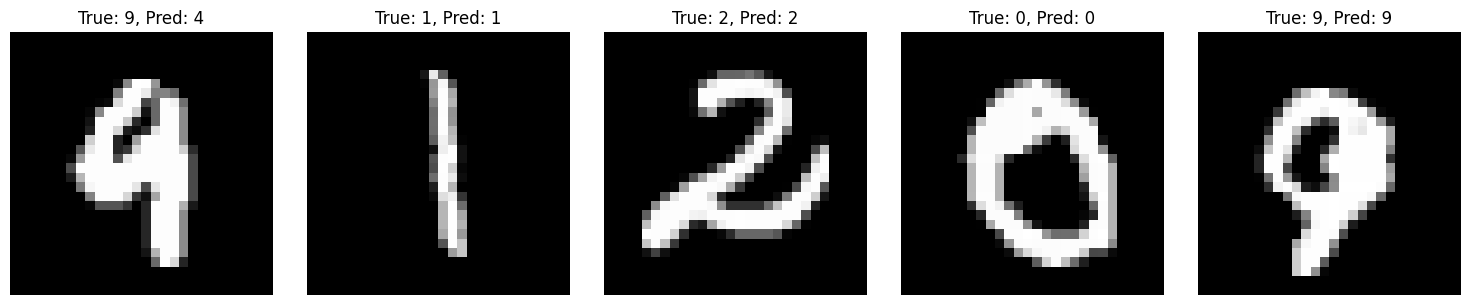

(<__main__.NeuralNetwork at 0x79ef581a0d50>,
 {'best_loss': 0.3542142440384551,
  'final_loss': 0.35735259455022006,
  'final_accuracy': 0.8945,
  'total_iterations': 3000,
  'execution_time': 1033.5990233421326,
  'history': {'loss': [2.2648610693054487,
    2.258268831573357,
    2.250945227328206,
    2.2476185871127816,
    2.2384082277477666,
    2.2351736984724337,
    2.2203951000663937,
    2.219759269924022,
    2.2117915959940713,
    2.2057066482721357,
    2.198104674634036,
    2.1980233027884255,
    2.191034176521597,
    2.1816129765878127,
    2.1689203441318443,
    2.1639615703263946,
    2.148941309335187,
    2.148941309335187,
    2.1375681889575535,
    2.134530865320945,
    2.1281484839232063,
    2.1281484839232063,
    2.115010897355857,
    2.0909969775626154,
    2.0909969775626154,
    2.0780776934552385,
    2.0756071870041954,
    2.0710447423309297,
    2.0660754057187174,
    2.0502021370408285,
    2.0409005550613384,
    2.0321430586767044,
    2.017

In [146]:
run_genetic_algorithm()